In [1]:
# import result data
import os
import csv

RESULT_PATH = 'testing/15-06-2023_22hh_16mm/'
AWS_IP_RANGES_PATH = '/Users/abdullah/Documents/PrimeVideo/PrimeVideo Scripts/aws-ip-ranges.json'

myimage_csv = "results/08-06-2023_04hh_56mm/myimage_08-06-2023_04hh_56mm.csv"
myvideo_csv = "results/08-06-2023_04hh_56mm/myvideo_08-06-2023_04hh_56mm.csv"

ringsofpower_vid_csv = "results/08-06-2023_04hh_56mm/ringsofpower_08-06-2023_04hh_56mm.csv"
citadel_csv = "results/08-06-2023_04hh_56mm/citadel_08-06-2023_04hh_56mm.csv"

samaritan_csv = "results/08-06-2023_04hh_56mm/samaritan_08-06-2023_04hh_56mm.csv"
godzilla_csv = "results/08-06-2023_04hh_56mm/godzilla_08-06-2023_04hh_56mm.csv"

harlem_csv = "results/08-06-2023_04hh_56mm/harlem_08-06-2023_04hh_56mm.csv"
marmaduke_csv = "results/08-06-2023_04hh_56mm/marmaduke_08-06-2023_04hh_56mm.csv"


def read_column_from_csv(file_path, column_name):
    column_values = []
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            column_values.append(row[column_name])
    return column_values

def read_columns_from_multiple_csv_files(directory_path, column_name):
    all_column_values = {}
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(directory_path, file_name)
            column_values = read_column_from_csv(file_path, column_name)
            all_column_values[file_name] = column_values
    return all_column_values

def get_all_column_values(column_name):
    directory_path = RESULT_PATH
    #column_name = 'latency(ms)'
    all_column_values = read_columns_from_multiple_csv_files(directory_path, column_name)
    #print(all_column_values)
    for i, column_values in all_column_values.items():
        pass
        #print(f'"{i}"')
        #print(i, column_values[:5])
    return all_column_values


In [2]:
### Functions to map IP to AWS related data

import json
import ipaddress

# reads AWS ip ranges from json publicly avaialble
def get_aws_ip_ranges():
    # Open the JSON file
    with open(AWS_IP_RANGES_PATH, 'r') as file:
        # Load the JSON data into a dictionary
        data = json.load(file)
        return data["prefixes"]

def map_ip_to_aws(ip_address, ranges_data_list):
    matching_aws_data = None
    
    try:
        ip = ipaddress.ip_address(ip_address)
    except Exception as e:
        print(ip_address, e)
        return matching_aws_data
    
    longest_prefix = -1
    matching_service = ""
    for range_data in ranges_data_list:
        subnet = range_data["ip_prefix"]
        network = ipaddress.ip_network(subnet)
        service = range_data["service"]
        region = range_data["region"]
        if ip in network and network.prefixlen >= longest_prefix:
            if service == "AMAZON" and matching_service != "AMAZON" and matching_service != "":
                continue
            matching_aws_data = range_data
            matching_service = service
            longest_prefix = network.prefixlen

    return matching_aws_data


# for testing
#responseIP = "18.165.185.120"
responseIP = "18.165.185.129"
subnet_list = get_aws_ip_ranges()
aws_data = map_ip_to_aws(responseIP, subnet_list)
print(responseIP,"\n",aws_data)

18.165.185.129 
 {'ip_prefix': '18.164.0.0/15', 'region': 'GLOBAL', 'service': 'CLOUDFRONT', 'network_border_group': 'GLOBAL'}


In [ ]:
### Add AWS Service info in the CSV files

import pandas as pd

ip_to_aws = {} # storing to avoid longest prefix match call to function

# Reads a column containing IPs from a csv and maps the IPs to AWS data
def get_ip_to_aws_data(dataname, ip_column, csv_filename):
    file_path = f"{RESULT_PATH}/{csv_filename}"
    ips = read_column_from_csv(file_path, ip_column)
    ranges_list = get_aws_ip_ranges()

    service_list = []
    
    for ip in ips:
        if ip in ip_to_aws:
            aws_data = ip_to_aws[ip]
        else:
            aws_data = map_ip_to_aws(ip, ranges_list)
        
        if aws_data:
            aws_service = aws_data[dataname]
        else:
            aws_service = ""
        
        service_list.append(aws_service)
        ip_to_aws[ip] = aws_data
        #print(ip_column, ":", ip, aws_service, csv_filename)
        #break
    
    return service_list

# Adds AWS related info for the resonseIP and X-Server-IP in the CSV file
def add_aws_data(csv_filename):
    resp_ip_service = get_ip_to_aws_data("service", "responseIP", csv_filename)
    resp_ip_region = get_ip_to_aws_data("region", "responseIP", csv_filename)
    resp_ip_prefix = get_ip_to_aws_data("ip_prefix", "responseIP", csv_filename)
    
    X_Server_IP_service = get_ip_to_aws_data("service", "X-Server-IP", csv_filename)
    X_Server_IP_region = get_ip_to_aws_data("region", "X-Server-IP", csv_filename)
    X_Server_IP_prefix = get_ip_to_aws_data("ip_prefix", "X-Server-IP", csv_filename)

    # Read the CSV file
    df = pd.read_csv(f'{RESULT_PATH}/{csv_filename}')

    
    # Define the position to insert the new column
    insert_position = df.columns.get_loc("responseIP") + 1
    # Insert the new column at the specified position with data
    if 'responseIP_service' not in df.columns:
        df.insert(insert_position, 'responseIP_service', resp_ip_service)
    
    # Define the position to insert the new column
    insert_position = df.columns.get_loc("responseIP") + 2
    # Insert the new column at the specified position with data
    if 'responseIP_region' not in df.columns:
        df.insert(insert_position, 'responseIP_region', resp_ip_region)
    
    # Define the position to insert the new column
    insert_position = df.columns.get_loc("responseIP") + 3
    # Insert the new column at the specified position with data
    if 'responseIP_prefix' not in df.columns:
        df.insert(insert_position, 'responseIP_prefix', resp_ip_prefix)

        
    # Define the position to insert the new column
    insert_position = df.columns.get_loc("X-Server-IP") + 1
    # Insert the new column at the specified position with data
    if 'X-Server-IP_service' not in df.columns:
        df.insert(insert_position, 'X-Server-IP_service', X_Server_IP_service)
    
    # Define the position to insert the new column
    insert_position = df.columns.get_loc("X-Server-IP") + 2
    # Insert the new column at the specified position with data
    if 'X-Server-IP_region' not in df.columns:
        df.insert(insert_position, 'X-Server-IP_region', X_Server_IP_region)
    
    # Define the position to insert the new column
    insert_position = df.columns.get_loc("X-Server-IP") + 3
    # Insert the new column at the specified position with data
    if 'X-Server-IP_prefix' not in df.columns:
        df.insert(insert_position, 'X-Server-IP_prefix', X_Server_IP_prefix)

    # Save the modified data back to the CSV file
    df.to_csv(f'{RESULT_PATH}/{csv_filename}', index=False)

# go through all csv result file and add in the aws service info
for file_name in os.listdir(RESULT_PATH):
    if file_name.endswith('.csv'):
        print(file_name)
        add_aws_data(file_name)
        '''
        # for testing, only add aws info in this file
        if "samaritan" in file_name:
            add_aws_data(file_name)
        '''
print("\nDONE.")

In [3]:
### LATENCY PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values_raw = get_all_column_values("latency(ms)")
all_column_values = {}
top_latency_avgs = []
nontop_latency_avgs = []
print("*** Avg latency ***")
for i, column_values in all_column_values_raw.items():
    column_values_float = []
    column_values_float_for_avg = []
    for value in column_values:
        if value == ' ':
            value = 0
            column_values_float.append(value_rounded) 
            continue # avoids adding 0 for calculating average
        value_rounded = round(float(value),2)
        column_values_float.append(value_rounded)
        column_values_float_for_avg.append(value_rounded)
        
    all_column_values[i] = column_values_float
    mean = round(np.mean(column_values_float_for_avg),2)
    confidence_interval = [round(val, 2) for val in stats.t.interval(0.90, len(column_values_float_for_avg) - 1, loc=mean, scale=stats.sem(column_values_float_for_avg))]
    if "_top_movie" in i:
        top_latency_avgs.append(mean)
        #print(i.split("_")[0],":\t", mean, "ms\t", " 90% CI:",confidence_interval)
        if mean >= 29:
            #print(i.split("_")[0],":\t", mean, "ms\t")
            print(i.split("_")[0])
    if "_top_" not in i:
        nontop_latency_avgs.append(mean)


*** Avg latency ***
Jolt
Monte Carlo
Rocky V
Eyes Wide Shut
The Manor
Fabrice Eboue  Plus rien a perdre
Three Steps Over Heaven 2004
Get Out
The Lost World Jurassic Park
Most Dangerous Game
Mr  Mrs Smith
Pitch Perfect 3
Knight and Day
Heat
Shazam
Split
Warcraft
LArte Della Truffa
Nella tana dei lupi
The Purge Anarchy
United fight
I dont love you either
True Story
Borat Subsequent Moviefilm
The Reef
Rosiko Show  Guai a perdere
Encounter
Nocturnal Animals
The Witch
Jaws
Jurassic Park III
Pride  Prejudice
Classico
Insidious The Last Key
ETThe ExtraTerrestrial
The Hangover Part II
Jumper
Meet Dave
My Policeman
The Revenant
Gangs of Lagos
Love and other drugs
The Aeronauts
The Bourne Legacy
The Hangover Part III
My Fake Boyfriend
The Wall
Goodnight Mommy
The Voyeurs
Unfaithful
Brutus vs Cesar
Slayers
The Report


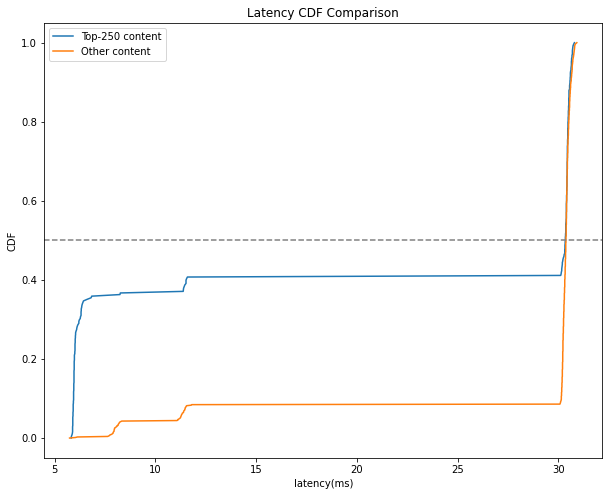

In [48]:
from statsmodels.distributions.empirical_distribution import ECDF

top_sorted = np.sort(top_latency_avgs)
nontop_sorted = np.sort(nontop_latency_avgs)

# Calculate the CDF values
top_ecdf = ECDF(top_sorted)
nontop_ecdf = ECDF(nontop_sorted)

# Calculate the median values
top_median = np.median(top_sorted)
nontop_median = np.median(nontop_sorted)

# Set the figure size
plt.figure(figsize=(10, 8))

# Plot the CDFs
plt.plot(top_sorted, top_cdf, label='Top-250 content')
plt.plot(nontop_sorted, nontop_cdf, label='Other content')

# Plot the median lines
plt.axhline(0.5, linestyle='--', color='grey')
#plt.axvline(top_median, linestyle='--', color='r')

#plt.axhline(0.5, linestyle='--', color='g', label='Median (Non-Top)')
#plt.axvline(nontop_median, linestyle='--', color='g')

# Set labels and title
plt.xlabel('latency(ms)')
plt.ylabel('CDF')
plt.title('Latency CDF Comparison')

# Show the legend
plt.legend()

# Display the plot
plt.show()

In [56]:
data = top_latency_avgs
#data = nontop_latency_avgs

count_below = sum(1 for value in data if value < 30)
percentage_below = (count_below / len(data)) * 100

print(f"The percentage of values below 30 ms is: {percentage_below:.2f}%")


import statistics

mean = statistics.mean(data)
median = statistics.median(data)
mode = statistics.mode(data)

print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)

The percentage of values below 30 ms is: 40.96%
Mean: 20.691204819277107
Median: 30.35
Mode: 30.45


In [16]:
### LATENCY PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values_raw = get_all_column_values("latency(ms)")
all_column_values = {}
print("*** Avg latency ***")
for i, column_values in all_column_values_raw.items():
    column_values_float = []
    column_values_float_for_avg = []
    for value in column_values:
        if value == ' ':
            value = 0
            column_values_float.append(value_rounded) 
            continue # avoids adding 0 for calculating average
        value_rounded = round(float(value),2)
        column_values_float.append(value_rounded)
        column_values_float_for_avg.append(value_rounded)
        
    all_column_values[i] = column_values_float
    mean = round(np.mean(column_values_float_for_avg),2)
    confidence_interval = [round(val, 2) for val in stats.t.interval(0.90, len(column_values_float_for_avg) - 1, loc=mean, scale=stats.sem(column_values_float_for_avg))]
    if "_top_" not in i:
        print(i.split("_")[0],":\t", mean, "ms\t", " 90% CI:",confidence_interval)

*** Avg latency ***
Photos instantanees :	 30.23 ms	  90% CI: [28.3, 32.16]
Lucky Dog :	 30.26 ms	  90% CI: [28.36, 32.16]
Gina Brillon The Floor is Lava :	 30.4 ms	  90% CI: [28.47, 32.33]
The Walking Dead :	 30.27 ms	  90% CI: [28.35, 32.19]
Arpeggio of Blue Steel  Ars Nova  Cadenza :	 30.73 ms	  90% CI: [28.81, 32.65]
The Crowned Clown :	 11.07 ms	  90% CI: [11.03, 11.11]
Ambition :	 30.31 ms	  90% CI: [28.38, 32.24]
A la recherche de lhomme immortel :	 30.08 ms	  90% CI: [28.18, 31.98]
Dumbbell :	 30.11 ms	  90% CI: [28.2, 32.02]
Jubilee :	 30.43 ms	  90% CI: [28.51, 32.35]
Les Crumpets :	 30.25 ms	  90% CI: [28.32, 32.18]
ORELSAN Dont ever show this to anyone :	 30.32 ms	  90% CI: [28.39, 32.25]
Hors de controle :	 30.35 ms	  90% CI: [28.43, 32.27]
Queen of Condoms :	 11.26 ms	  90% CI: [11.21, 11.31]
Blood Ties :	 8.05 ms	  90% CI: [7.98, 8.12]
Campus Galli Das Mittelalterexperiment :	 30.41 ms	  90% CI: [28.48, 32.34]
Donkey Kong Country :	 30.2 ms	  90% CI: [28.29, 32.11]
Starb

Sherlock Holmes  le chien des Baskerville :	 8.21 ms	  90% CI: [8.12, 8.3]
Lenas Ranch :	 30.43 ms	  90% CI: [28.5, 32.36]
Rescue Team :	 30.56 ms	  90% CI: [28.66, 32.46]
Botticelli  Inferno :	 11.41 ms	  90% CI: [11.34, 11.48]
Rob Delaney Jackie :	 30.42 ms	  90% CI: [28.49, 32.35]
The Three Drinkers in Ireland :	 30.15 ms	  90% CI: [28.25, 32.05]
Sinfonie der Liebe :	 30.17 ms	  90% CI: [28.24, 32.1]
40 Days At Base Camp :	 30.46 ms	  90% CI: [28.53, 32.39]
NotreDame de Paris :	 30.2 ms	  90% CI: [28.27, 32.13]
Dino Dana :	 30.69 ms	  90% CI: [28.76, 32.62]
Over the North of Maine :	 30.43 ms	  90% CI: [28.51, 32.35]
Star Blazers 2199  Space Battleship Yamato :	 30.39 ms	  90% CI: [28.47, 32.31]
Squadra Criminale VF :	 30.27 ms	  90% CI: [28.34, 32.2]
Mon Ami Grompf :	 30.41 ms	  90% CI: [28.51, 32.31]
La petite Lady :	 30.66 ms	  90% CI: [28.74, 32.58]
Un roman damour :	 30.4 ms	  90% CI: [28.49, 32.31]
DarkWeb :	 30.22 ms	  90% CI: [28.31, 32.13]
The Flight Attendant :	 30.34 ms	 

Ces animaux qui nous etonnent :	 30.62 ms	  90% CI: [28.7, 32.54]
2 Lava 2 Lantula :	 30.58 ms	  90% CI: [28.68, 32.48]
Tom Tom et Nana :	 30.46 ms	  90% CI: [28.55, 32.37]
Amsterdamned :	 11.3 ms	  90% CI: [11.24, 11.36]
Inside Rakka ISDeserteure packen aus :	 11.32 ms	  90% CI: [11.26, 11.38]
Monsieur Lapin :	 30.4 ms	  90% CI: [28.49, 32.31]
Mafia Undercover :	 30.38 ms	  90% CI: [28.46, 32.3]
Signe Chanel :	 30.75 ms	  90% CI: [28.83, 32.67]
Fakes Farzi :	 30.31 ms	  90% CI: [28.38, 32.24]
Parrain mais pas trop :	 30.23 ms	  90% CI: [28.32, 32.14]
Filthy Envy :	 30.32 ms	  90% CI: [28.42, 32.22]
Beautiful Bones :	 30.24 ms	  90% CI: [28.31, 32.17]
As We Forgive :	 30.45 ms	  90% CI: [28.52, 32.38]
H2O Plotzlich Meerjungfrau dtOV :	 11.48 ms	  90% CI: [11.41, 11.55]
Junjo Romantica :	 30.38 ms	  90% CI: [28.46, 32.3]
Harlem :	 30.68 ms	  90% CI: [28.76, 32.6]
Mylene Farmer LUltime Creation :	 30.48 ms	  90% CI: [28.56, 32.4]
Sharknado 2 :	 30.48 ms	  90% CI: [28.55, 32.41]
Federico 

Motherland Fort Salem :	 30.41 ms	  90% CI: [28.49, 32.33]
Festen Fete de Famille :	 30.58 ms	  90% CI: [28.65, 32.51]
Home :	 30.61 ms	  90% CI: [28.69, 32.53]
Kendrick Lamar Live The Big Steppers Tour :	 30.48 ms	  90% CI: [28.58, 32.38]
Naruto Shippuden  La tour perdue :	 30.69 ms	  90% CI: [28.76, 32.62]
The Ave :	 30.2 ms	  90% CI: [28.28, 32.12]
Napoleon Life of an Outlaw :	 30.3 ms	  90% CI: [28.37, 32.23]
Sofia Nino de Rivera Stand Up Special :	 30.34 ms	  90% CI: [28.42, 32.26]
Cuento de Primavera A Spring Tale :	 30.27 ms	  90% CI: [28.36, 32.18]
Les contes de Grimm :	 30.48 ms	  90% CI: [28.56, 32.4]
Dead Space  Aftermath :	 30.53 ms	  90% CI: [28.61, 32.45]
Poliana Moca :	 30.35 ms	  90% CI: [28.45, 32.25]
LUPIN THE 3rd vs CATS EYE :	 30.36 ms	  90% CI: [28.44, 32.28]
Carnivale :	 11.28 ms	  90% CI: [11.22, 11.34]
Histoire trouble :	 30.19 ms	  90% CI: [28.27, 32.11]
IncrediTales :	 30.15 ms	  90% CI: [28.24, 32.06]
Dinosaur Experiment :	 30.53 ms	  90% CI: [28.62, 32.44]
S

Square One Michael Jackson :	 30.6 ms	  90% CI: [28.68, 32.52]
FateGrand Order Absolute Demonic Front Babylonia :	 30.41 ms	  90% CI: [28.49, 32.33]
Snake Eyes GI Joe Origins :	 30.64 ms	  90% CI: [28.74, 32.54]
Florence :	 30.61 ms	  90% CI: [28.69, 32.53]
Aurora Teagarden  la maison des disparus :	 30.38 ms	  90% CI: [28.46, 32.3]
Drive Angry :	 30.92 ms	  90% CI: [29.01, 32.83]
Le Chateau des Singes :	 7.91 ms	  90% CI: [7.85, 7.97]
Lucky Luke  Go West :	 30.29 ms	  90% CI: [28.38, 32.2]
Fatestay night Heavens Feel II lost butterfly :	 30.57 ms	  90% CI: [28.65, 32.49]
El Candidato :	 30.3 ms	  90% CI: [28.39, 32.21]
Bosses :	 30.36 ms	  90% CI: [28.45, 32.27]
Tutto puo cambiare :	 30.69 ms	  90% CI: [28.77, 32.61]
Mom The Complete Series :	 11.8 ms	  90% CI: [11.72, 11.88]
Il 13deg Segno :	 30.28 ms	  90% CI: [28.35, 32.21]
The Best Summer of Our Lives :	 30.19 ms	  90% CI: [28.27, 32.11]
Bonne nuit dit mlle Bird :	 30.53 ms	  90% CI: [28.63, 32.43]
Bebe Requin Chansons pour Enfant

In [6]:
### HOPCOUNT PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


all_column_values = {}
all_column_values_raw = get_all_column_values("hop count")
print("*** Avg Hop Counts ***")
for i, column_values in all_column_values_raw.items():
    if "myimage" in i or "samaritan" in i:
        column_values = all_column_values[i]
        column_values_int_for_avg = all_column_values[i]
    column_values_int_for_avg = [int(value) for value in column_values if value != ' '] # ignore 0s for average
    column_values_int = [int(value) if value != " " else None for value in column_values] # maps '' to 0
    all_column_values[i] = column_values_int
    mean = round(np.mean(column_values_int_for_avg),2)
    confidence_interval = [round(val, 1) for val in stats.t.interval(0.90, len(column_values_int_for_avg) - 1, loc=mean, scale=stats.sem(column_values_int_for_avg))]
    if "_top_" in i:
        print(i.split("_")[0],":\t", mean)

'''   
### For Popular

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the numerical values for each website response
for filename, column_values in all_column_values.items():
    if "citadel" in filename or "myvideo" in filename or "ringsofpower" in filename or "myimage" in filename:
        name = filename.split("_")[0]
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
ax.set_title('Path length for Popular Content')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()



### For UnPopular

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the numerical values for each website response
for filename, column_values in all_column_values.items():
    # ignore since they used IPv6
    #if "citadel" in filename or "myvideo" in filename or "ringsofpower" in filename:
    if "godzilla" in filename or "marmaduke" in filename or "samaritan" in filename:
        name = filename.split("_")[0]
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
ax.set_title('Path length for Unpopular Content')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()
''' 

*** Avg Hop Counts ***
Dead Ringers :	 20.47
LOL  Last One Laughing Spain :	 20.47
GREEK SALAD :	 20.47
Jolt :	 20.47
Monte Carlo :	 20.47
House of Gucci :	 5.0
Rocky V :	 20.47
Supernatural :	 20.47
Man on Fire :	 17.0
The People We Hate At The Wedding :	 17.0
Eyes Wide Shut :	 20.47
The Gryphon :	 17.0
The Walking Dead World Beyond :	 20.47
The Manor :	 20.47
Pretty Little Liars :	 20.47
The Marvelous Mrs Maisel :	 17.0
Coeurs Noirs :	 5.0
Samaritan :	 17.0
The Purge :	 20.47
Tom Clancys Jack Ryan :	 17.0
Class of 07 :	 20.47
Creed III :	 17.0
The Legend of Vox Machina :	 5.0
American Gods :	 20.47
Chicago PD :	 20.47
Ultimo  Vivo coi sogni appesi :	 17.0
The Lord of the Rings The Return of the King :	 17.0
Doctor Who :	 20.47
Terminator 2 Dommedag :	 17.0
The Mentalist :	 20.47
Fifty Shades Darker :	 17.0
Outer Range :	 20.47
Deep Water :	 17.0
The Hobbit The Battle of the Five Armies :	 17.0
The Lake :	 20.47
Fabrice Eboue  Plus rien a perdre :	 20.47
The Grand Tour :	 17.0
Salam :

/Users/abdullah/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/abdullah/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


High Crimes :	 5.0
Rocky Balboa :	 17.0
Pitch Perfect 3 :	 20.47
Night Sky :	 20.47
Creed II :	 17.0
Veronica Mars :	 20.47
The Night Manager :	 20.47
Knight and Day :	 20.47
Heat :	 20.47
Back to the Future :	 17.0
Carnival Row :	 17.0
Citadel :	 17.0
Homecoming :	 5.25
Upload :	 20.47
The Hobbit An Unexpected Journey :	 17.0
House :	 20.47
Shazam :	 20.47
TIME IS UP :	 17.0
Split :	 20.47
Sayen :	 17.0
The Wheel of Time :	 17.0
A Private Affair :	 5.28
The Boys :	 17.0
Invincible :	 20.47
Warcraft :	 20.47
The Peripheral :	 17.0
LArte Della Truffa :	 20.47
Shameless :	 17.0
The Boss Baby :	 17.0
The Bourne Ultimatum :	 17.0
First Love :	 17.0
Nella tana dei lupi :	 20.47
Rocky :	 17.0
The Purge Anarchy :	 20.47
Rocky III :	 17.0
Fleabag :	 20.47
Demon Slayer :	 20.47
Mad Men :	 20.47
Nine Perfect Strangers :	 20.47
Daisy Jones and The Six :	 20.47
Little Fires Everywhere :	 20.47
This Is Us :	 20.47
Celebrity Hunted  France  Manhunt :	 20.47
Star Trek Picard :	 20.47
112263 :	 20.47


'   \n### For Popular\n\n# Define the time series for the x-axis\nmax_time = max( len(values) for values in all_column_values.values() )\ntime = range(max_time)\n\n# Create a figure and axis\nfig, ax = plt.subplots()\n\n# Plot the numerical values for each website response\nfor filename, column_values in all_column_values.items():\n    if "citadel" in filename or "myvideo" in filename or "ringsofpower" in filename or "myimage" in filename:\n        name = filename.split("_")[0]\n        ax.plot(time[:len(column_values)], column_values, label=name)\n\n# Set the x-axis and y-axis labels\nax.set_xlabel(\'Time\', fontsize=12)\nax.set_ylabel(\'Hops\', fontsize=12)\n\n# Set the title of the plot\nax.set_title(\'Path length for Popular Content\')\n\n# Add a legend with a white background and increased font size\nax.legend(facecolor=\'white\', fontsize=8)\n\n# Adjust the figure size and spacing between subplots\nfig.set_size_inches(16, 8)\nfig.tight_layout()\n\n# Adjust the limits of the x-axi

In [9]:
### Hit vs Miss Stats Comparison

import pandas as pd
import numpy as np

for file_name in os.listdir(RESULT_PATH):
    if file_name.endswith('.csv'):
        name = file_name.split("_")[0]
        
        file_path = os.path.join(RESULT_PATH, file_name)
        df = pd.read_csv(file_path)
        
        # Filter the rows with x-cache = hit or miss
        filtered_df1 = df[df['X-Cache'] == 'Miss from cloudfront']
        latencies_miss = filtered_df1['latency(ms)'].tolist()
        latencies_miss = pd.to_numeric(latencies_miss, errors='coerce')
        hops_miss = filtered_df1['hop count'].tolist()
        hops_miss = pd.to_numeric(hops_miss, errors='coerce')
        
        filtered_df2 = df[df['X-Cache'] == 'Hit from cloudfront']
        latencies_hit = filtered_df2['latency(ms)'].tolist()
        latencies_hit = pd.to_numeric(latencies_hit, errors='coerce')
        hops_hit = filtered_df2['hop count'].tolist()
        hops_hit = pd.to_numeric(hops_hit, errors='coerce')
        if "_top_" in file_name:
            print(name)
            print("Miss:\t","avg-latency:",round(np.mean(latencies_miss),2),"ms\t", "avg-hops:",round(np.mean(hops_miss),0))
            print("Hit:\t","avg-latency:",round(np.mean(latencies_hit),2),"ms\t", "avg-hops:",round(np.mean(hops_hit),0))
            print("\n\n")

Dead Ringers
Miss:	 avg-latency: 61.01 ms	 avg-hops: 22.0
Hit:	 avg-latency: 30.27 ms	 avg-hops: 20.0



LOL  Last One Laughing Spain
Miss:	 avg-latency: 55.38 ms	 avg-hops: 22.0
Hit:	 avg-latency: nan ms	 avg-hops: 20.0



GREEK SALAD
Miss:	 avg-latency: 57.1 ms	 avg-hops: 22.0
Hit:	 avg-latency: nan ms	 avg-hops: 20.0



Jolt
Miss:	 avg-latency: 63.81 ms	 avg-hops: 22.0
Hit:	 avg-latency: 30.37 ms	 avg-hops: 20.0



Monte Carlo
Miss:	 avg-latency: 46.12 ms	 avg-hops: 22.0
Hit:	 avg-latency: 30.26 ms	 avg-hops: 20.0



House of Gucci
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: nan ms	 avg-hops: nan



Rocky V
Miss:	 avg-latency: 53.65 ms	 avg-hops: 22.0
Hit:	 avg-latency: nan ms	 avg-hops: 20.0



Supernatural
Miss:	 avg-latency: 71.24 ms	 avg-hops: 22.0
Hit:	 avg-latency: nan ms	 avg-hops: 20.0



Man on Fire
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: 5.91 ms	 avg-hops: 17.0



The People We Hate At The Wedding
Miss:	 avg-latency: nan ms	 avg-hops: 

The Hobbit An Unexpected Journey
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: 5.92 ms	 avg-hops: 17.0



House
Miss:	 avg-latency: 161.46 ms	 avg-hops: 28.0
Hit:	 avg-latency: 30.2 ms	 avg-hops: 20.0



Shazam
Miss:	 avg-latency: 56.65 ms	 avg-hops: 22.0
Hit:	 avg-latency: nan ms	 avg-hops: 20.0



TIME IS UP
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: 5.92 ms	 avg-hops: 17.0



Split
Miss:	 avg-latency: 53.37 ms	 avg-hops: 22.0
Hit:	 avg-latency: nan ms	 avg-hops: 20.0



Sayen
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: 5.86 ms	 avg-hops: 17.0



The Wheel of Time
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: 5.97 ms	 avg-hops: 17.0



A Private Affair
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: nan ms	 avg-hops: nan



The Boys
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: 6.22 ms	 avg-hops: 17.0



Invincible
Miss:	 avg-latency: 64.77 ms	 avg-hops: 23.0
Hit:	 avg-latency: nan ms	 avg-ho

No Time to Die
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: 6.01 ms	 avg-hops: 17.0



The Originals
Miss:	 avg-latency: 56.88 ms	 avg-hops: 22.0
Hit:	 avg-latency: 30.21 ms	 avg-hops: 20.0



Classico
Miss:	 avg-latency: 47.56 ms	 avg-hops: 22.0
Hit:	 avg-latency: 30.09 ms	 avg-hops: 20.0



The Hobbit The Desolation of Smaug
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: 5.83 ms	 avg-hops: 17.0



Insidious The Last Key
Miss:	 avg-latency: 63.11 ms	 avg-hops: 22.0
Hit:	 avg-latency: 30.06 ms	 avg-hops: 20.0



The Bourne Supremacy
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: 5.94 ms	 avg-hops: 17.0



I Know What You Did Last Summer
Miss:	 avg-latency: 54.6 ms	 avg-hops: 22.0
Hit:	 avg-latency: 30.3 ms	 avg-hops: 20.0



Downton Abbey
Miss:	 avg-latency: 57.49 ms	 avg-hops: 22.0
Hit:	 avg-latency: 30.31 ms	 avg-hops: 20.0



Clarksons Farm
Miss:	 avg-latency: 56.37 ms	 avg-hops: 22.0
Hit:	 avg-latency: nan ms	 avg-hops: 20.0



Deadloch
M

The Lord of The Rings The Two Towers
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: 5.92 ms	 avg-hops: 17.0



The Last Ship The Complete Series
Miss:	 avg-latency: 59.87 ms	 avg-hops: 22.0
Hit:	 avg-latency: nan ms	 avg-hops: 20.0



The Report
Miss:	 avg-latency: 153.77 ms	 avg-hops: 28.0
Hit:	 avg-latency: 30.29 ms	 avg-hops: 20.0



The Lord of the Rings The Rings of Power
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: 6.03 ms	 avg-hops: 17.0



Paradise Cove
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: 5.96 ms	 avg-hops: 17.0



Bones and All
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: 5.94 ms	 avg-hops: 17.0



Reacher
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: 6.31 ms	 avg-hops: 17.0



Shiny Happy People Duggar Family Secrets
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: 6.02 ms	 avg-hops: 17.0



Creed
Miss:	 avg-latency: nan ms	 avg-hops: nan
Hit:	 avg-latency: 5.97 ms	 avg-hops: 17.

In [14]:
### X-Cache Hit PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from collections import Counter

def calculate_percentage_distribution(lst):
    counter = Counter(lst)
    total_count = len(lst)
    distribution = {}

    for value, count in counter.items():
        percentage = (count / total_count) * 100
        distribution[value] = round(percentage,2)

    sorted_distribution = dict(sorted(distribution.items(), key=lambda x: x[1], reverse=True))
    return sorted_distribution

all_column_values = get_all_column_values("X-Cache")

print("*** Cache hit/miss ***")
for filename, column_values in all_column_values.items():
    if "_top_" in filename:
        name = filename.split("_")[0]
        print(f"\n\n{name}:")
        distribution = calculate_percentage_distribution(column_values)
        for value, percentage in distribution.items():
            if value == ' ':
                value = "Empty"
            print(f"\t- {value}: {percentage}%")
'''
all_column_values = get_all_column_values("X-Cache")

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()
'''

*** Cache hit/miss ***


Dead Ringers:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


LOL  Last One Laughing Spain:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


GREEK SALAD:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


Jolt:
	- Hit from cloudfront: 99.62%
	- Miss from cloudfront: 0.38%


Monte Carlo:
	- Hit from cloudfront: 99.36%
	- Miss from cloudfront: 0.64%


House of Gucci:
	- Empty: 100.0%


Rocky V:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


Supernatural:
	- Hit from cloudfront: 99.62%
	- Miss from cloudfront: 0.38%


Man on Fire:
	- Hit from cloudfront: 99.74%
	- Empty: 0.26%


The People We Hate At The Wedding:
	- Hit from cloudfront: 100.0%


Eyes Wide Shut:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


The Gryphon:
	- Hit from cloudfront: 100.0%


The Walking Dead World Beyond:
	- Hit from cloudfront: 99.87%
	- Miss from cloudfront: 0.13%


The Manor:
	- Hit from cloudfront: 99.87%


'\nall_column_values = get_all_column_values("X-Cache")\n\n# Define the time series for the x-axis\nmax_time = max( len(values) for values in all_column_values.values() )\ntime = range(max_time)\n\n# Create a figure and axis\nfig, ax = plt.subplots()\n\n# Plot the values for each website response\nfor filename, column_values in all_column_values.items():\n    name = filename.split("_")[0]\n    ax.plot(time[:len(column_values)], column_values, label=name)\n\n# Set the x-axis and y-axis labels\nax.set_xlabel(\'Time\', fontsize=12)\n#ax.set_ylabel(\'Hops\', fontsize=12)\n\n# Set the title of the plot\n#ax.set_title(\'Numerical Value Changes for Website Responses\')\n\n# Add a legend with a white background and increased font size\nax.legend(facecolor=\'white\', fontsize=8)\n\n# Adjust the figure size and spacing between subplots\nfig.set_size_inches(16, 8)\nfig.tight_layout()\n\n# Adjust the limits of the x-axis and y-axis to remove excess space\nax.set_xlim(0, max_time - 1)\n\n# Add grid

In [13]:
### X-Cache Hit PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from collections import Counter

def calculate_percentage_distribution(lst):
    counter = Counter(lst)
    total_count = len(lst)
    distribution = {}

    for value, count in counter.items():
        percentage = (count / total_count) * 100
        distribution[value] = round(percentage,2)

    sorted_distribution = dict(sorted(distribution.items(), key=lambda x: x[1], reverse=True))
    return sorted_distribution

all_column_values = get_all_column_values("X-Cache")

print("*** Cache hit/miss ***")
for filename, column_values in all_column_values.items():
    if "_top_" not in filename:
        name = filename.split("_")[0]
        print(f"\n\n{name}:")
        distribution = calculate_percentage_distribution(column_values)
        for value, percentage in distribution.items():
            if value == ' ':
                value = "Empty"
            print(f"\t- {value}: {percentage}%")
'''
all_column_values = get_all_column_values("X-Cache")

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()
'''

*** Cache hit/miss ***


Photos instantanees:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


Lucky Dog:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


Gina Brillon The Floor is Lava:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


The Walking Dead:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


Arpeggio of Blue Steel  Ars Nova  Cadenza:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


The Crowned Clown:
	- Empty: 100.0%


Ambition:
	- Hit from cloudfront: 99.62%
	- Miss from cloudfront: 0.38%


A la recherche de lhomme immortel:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


Dumbbell:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


Jubilee:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


Les Crumpets:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


ORELSAN Dont ever show this to anyone:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront:

	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


LOL Last One Laughing Netherlands:
	- Empty: 100.0%


Roter Staub:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


Atomic Shark:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


Ice:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


Hot School 2:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


Dernier train de la nuit:
	- Hit from cloudfront: 99.62%
	- Miss from cloudfront: 0.38%


Quick  Die Erschaffung eines Serienkillers:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


Spains Elite Police Beyond limits:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


Lo chiamavano Jeeg Robot:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


The Bad Guy:
	- Hit from cloudfront: 99.62%
	- Miss from cloudfront: 0.38%


The Challenge 11M:
	- Hit from cloudfront: 99.49%
	- Miss from cloudfront: 0.51%


DeutschLesLandes VERSION FRANCAIS

'\nall_column_values = get_all_column_values("X-Cache")\n\n# Define the time series for the x-axis\nmax_time = max( len(values) for values in all_column_values.values() )\ntime = range(max_time)\n\n# Create a figure and axis\nfig, ax = plt.subplots()\n\n# Plot the values for each website response\nfor filename, column_values in all_column_values.items():\n    name = filename.split("_")[0]\n    ax.plot(time[:len(column_values)], column_values, label=name)\n\n# Set the x-axis and y-axis labels\nax.set_xlabel(\'Time\', fontsize=12)\n#ax.set_ylabel(\'Hops\', fontsize=12)\n\n# Set the title of the plot\n#ax.set_title(\'Numerical Value Changes for Website Responses\')\n\n# Add a legend with a white background and increased font size\nax.legend(facecolor=\'white\', fontsize=8)\n\n# Adjust the figure size and spacing between subplots\nfig.set_size_inches(16, 8)\nfig.tight_layout()\n\n# Adjust the limits of the x-axis and y-axis to remove excess space\nax.set_xlim(0, max_time - 1)\n\n# Add grid

In [ ]:
### AGE PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values_raw = get_all_column_values("Age")
all_column_values = {}

for i, column_values in all_column_values_raw.items():
    # ignore since their Age columns is always empty
    if "marmaduke" in i or "citadel" in i or "godzilla" in i:
        continue
    column_values_int = [int(value)/60 if value != " " else None for value in column_values] # maps '' to None 
    all_column_values[i] = column_values_int

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    plt.plot(time[:len(column_values)], column_values, label=name)

    # Set the x-axis and y-axis labels
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Age (sec)', fontsize=12)

    # Set the title of the plot
    plt.title(name)

    # Add a legend with a white background and increased font size
    plt.legend(facecolor='white', fontsize=8)

    # Adjust the figure size and spacing between subplots
    plt.gcf().set_size_inches(4, 4)
    plt.tight_layout()

    # Adjust the limits of the x-axis and y-axis to remove excess space
    plt.xlim(0, max_time - 1)

    # Add gridlines for better readability
    plt.grid(True, linestyle='--', alpha=0.5)

    # Display the plot
    plt.show()

In [4]:
import geoip2.database
import json
 

def ip_to_location(ip_address):
    # Load the GeoIP2 database
    reader = geoip2.database.Reader('GeoLite2-City.mmdb')
    
    try:
        # Perform the IP lookup
        response = reader.city(ip_address)

        # Get the city name
        city_name = response.city.name
        country_name = response.country.name
    
    except Exception as e:
        return ["", ""]

    # Close the GeoIP2 reader
    reader.close()
    return [city_name, country_name]


def iata_to_location(iata_code):
    iata_code = iata_code[:3]
    # Open the JSON file
    with open('/Users/abdullah/Documents/PrimeVideo/PrimeVideo Scripts/cloudfront-edge-locations.json', 'r') as file:
        # Load the JSON data into a dictionary
        data = json.load(file)
    
    iata_to_location = {}
    for iata, info in data["nodes"].items():
        country = info["country"]
        city = info["city"]
        airport = info["airport"]
        iata_to_location[iata] = [city, country, airport]
        #print(iata, city)
    
    if iata_code in iata_to_location:
        return iata_to_location[iata_code]
    else:
        return ["","",""]


if __name__ == '__main__':
    # testing
    ip_address = '54.182.218.106'
    location = ip_to_location(ip_address)
    print(f"{ip_address} is mapped to {location}")

    iata_code = "BNE50-P2"
    location = iata_to_location(iata_code)
    print(f"{iata_code} is mapped to {location[:2]}") # print only city and country

54.182.218.106 is mapped to [None, 'United States']
BNE50-P2 is mapped to ['Brisbane', 'Australia']


In [ ]:
### CloudFront Edge Locations PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("X-Amz-Cf-Pop")

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    if "citadel" in filename or "myvideo" in filename or "ringsofpower" in filename or "myimage" in filename:
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

all_values = [item for sublist in all_column_values.values() for item in sublist]
all_codes = list(set(all_values))
all_codes.sort()

for code in all_codes:
    if len(code)>3:
        location = iata_to_location(code)
        print(code,"=", location[0], location[1])

# format = IATACode<DatacenterCode>-Cluster<ClusterNumber> (I assumed)
# e.g, ZRH55-P1
# It is not possible to determine the exact meaning without access to Amazon's internal documentation.

In [ ]:
### CloudFront Edge Locations (UNpopular content) PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("X-Amz-Cf-Pop")

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    if "godzilla" in filename or "marmaduke" in filename or "harlem" in filename:
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

all_values = [item for sublist in all_column_values.values() for item in sublist]
all_codes = list(set(all_values))
all_codes.sort()

for code in all_codes:
    if len(code)>3:
        location = iata_to_location(code)
        print(code,"=", location[0], location[1])

# format = IATACode<DatacenterCode>-Cluster<ClusterNumber> (I assumed)
# e.g, ZRH55-P1
# It is not possible to determine the exact meaning without access to Amazon's internal documentation.

In [6]:
### CloudFront Edge Locations (UNpopular content) PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("X-Amz-Cf-Pop")


all_values = [item for sublist in all_column_values.values() for item in sublist]
all_codes = list(set(all_values))
all_codes.sort()

for code in all_codes:
    if len(code)>3:
        location = iata_to_location(code)
        print(code,"=", location[0], location[1])

# format = IATACode<DatacenterCode>-Cluster<ClusterNumber> (I assumed)
# e.g, ZRH55-P1
# It is not possible to determine the exact meaning without access to Amazon's internal documentation.

AMS51-M1 = Amsterdam Netherlands
AMS52-M2 = Amsterdam Netherlands
AMS53-M3 = Amsterdam Netherlands
FRA51-M1 = Frankfurt Germany
FRA52-M2 = Frankfurt Germany
FRA54-M3 = Frankfurt Germany
LHR4-M1 = London United Kingdom
LHR50-M1 = London United Kingdom
LHR51-M2 = London United Kingdom
LHR52-M3 = London United Kingdom
LHR61-M2 = London United Kingdom
LHR62-M3 = London United Kingdom
SFO20-M2 = San Francisco, CA United States
SFO5-M1 = San Francisco, CA United States
SFO50-M3 = San Francisco, CA United States
ZRH55-P1 = Zürich Switzerland


In [15]:
### CloudFront Edge Locations PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from collections import Counter

def calculate_percentage_distribution(lst):
    counter = Counter(lst)
    total_count = len(lst)
    distribution = {}

    for value, count in counter.items():
        percentage = (count / total_count) * 100
        distribution[value] = round(percentage,2)

    sorted_distribution = dict(sorted(distribution.items(), key=lambda x: x[1], reverse=True))
    return sorted_distribution

print("***** Distribution *****")

all_column_values = get_all_column_values("X-Amz-Cf-Pop")
for filename, column_values in all_column_values.items():
    if "_top_" not in filename:
        distribution = calculate_percentage_distribution(column_values)
        name = filename.split("_")[0]
        print(f"\n{name}:")
        for value, percentage in distribution.items():
            if value == ' ':
                value = "empty"
            print(f"\t- {value}: {percentage}%")

***** Distribution *****

Photos instantanees:
	- AMS51-M1: 13.83%
	- AMS52-M2: 10.5%
	- AMS53-M3: 10.24%
	- LHR4-M1: 7.43%
	- LHR52-M3: 7.3%
	- LHR50-M1: 6.91%
	- FRA51-M1: 6.66%
	- FRA54-M3: 6.66%
	- LHR51-M2: 6.53%
	- FRA52-M2: 6.15%
	- LHR61-M2: 5.63%
	- LHR62-M3: 5.63%
	- SFO50-M3: 2.43%
	- SFO5-M1: 2.18%
	- SFO20-M2: 1.92%

Lucky Dog:
	- AMS53-M3: 13.06%
	- AMS52-M2: 11.65%
	- AMS51-M1: 9.99%
	- LHR51-M2: 7.81%
	- LHR4-M1: 7.43%
	- LHR62-M3: 6.91%
	- FRA51-M1: 6.66%
	- FRA54-M3: 6.53%
	- LHR61-M2: 6.4%
	- FRA52-M2: 6.27%
	- LHR52-M3: 6.02%
	- LHR50-M1: 4.87%
	- SFO5-M1: 2.82%
	- SFO50-M3: 2.05%
	- SFO20-M2: 1.54%

Gina Brillon The Floor is Lava:
	- AMS52-M2: 12.55%
	- AMS53-M3: 11.27%
	- AMS51-M1: 10.88%
	- LHR4-M1: 7.55%
	- FRA54-M3: 7.17%
	- LHR62-M3: 6.91%
	- LHR52-M3: 6.91%
	- FRA52-M2: 6.66%
	- LHR51-M2: 6.66%
	- LHR50-M1: 6.4%
	- FRA51-M1: 5.76%
	- LHR61-M2: 4.74%
	- SFO50-M3: 2.3%
	- SFO5-M1: 2.18%
	- SFO20-M2: 2.05%

The Walking Dead:
	- AMS53-M3: 12.55%
	- AMS52-M2: 11.5

	- LHR50-M1: 6.53%
	- LHR61-M2: 6.4%
	- FRA51-M1: 5.76%
	- LHR62-M3: 5.12%
	- SFO5-M1: 2.3%
	- SFO50-M3: 2.18%
	- SFO20-M2: 1.92%

Voyage au centre de la Terre:
	- AMS52-M2: 11.91%
	- AMS53-M3: 11.78%
	- AMS51-M1: 11.01%
	- FRA54-M3: 8.45%
	- LHR4-M1: 7.81%
	- LHR61-M2: 6.91%
	- LHR52-M3: 6.79%
	- LHR51-M2: 6.53%
	- LHR62-M3: 6.02%
	- FRA51-M1: 5.76%
	- FRA52-M2: 5.51%
	- LHR50-M1: 5.12%
	- SFO20-M2: 2.3%
	- SFO5-M1: 2.05%
	- SFO50-M3: 2.05%

Nabilla Sans filtre:
	- empty: 100.0%

Overlord:
	- AMS52-M2: 13.7%
	- AMS53-M3: 11.01%
	- AMS51-M1: 9.99%
	- LHR52-M3: 7.68%
	- FRA54-M3: 7.3%
	- LHR4-M1: 6.79%
	- LHR61-M2: 6.66%
	- LHR51-M2: 6.66%
	- FRA51-M1: 6.4%
	- LHR50-M1: 6.15%
	- FRA52-M2: 5.89%
	- LHR62-M3: 5.25%
	- SFO20-M2: 2.56%
	- SFO5-M1: 2.43%
	- SFO50-M3: 1.54%

No Game No Life Zero:
	- AMS53-M3: 12.68%
	- AMS52-M2: 11.91%
	- AMS51-M1: 10.12%
	- LHR51-M2: 8.32%
	- LHR4-M1: 7.68%
	- LHR62-M3: 7.55%
	- FRA51-M1: 6.91%
	- FRA54-M3: 6.79%
	- LHR50-M1: 6.02%
	- FRA52-M2: 5.89%
	- LHR5

GUILTY MINDS:
	- AMS53-M3: 12.68%
	- AMS52-M2: 12.04%
	- AMS51-M1: 9.86%
	- FRA52-M2: 8.19%
	- LHR51-M2: 7.55%
	- LHR62-M3: 6.79%
	- LHR4-M1: 6.79%
	- LHR52-M3: 6.79%
	- FRA51-M1: 6.02%
	- LHR61-M2: 5.76%
	- LHR50-M1: 5.63%
	- FRA54-M3: 5.38%
	- SFO5-M1: 2.3%
	- SFO50-M3: 2.18%
	- SFO20-M2: 2.05%

Them:
	- AMS51-M1: 12.93%
	- AMS52-M2: 11.52%
	- AMS53-M3: 10.12%
	- LHR4-M1: 7.55%
	- LHR52-M3: 7.17%
	- FRA54-M3: 7.04%
	- FRA52-M2: 6.91%
	- LHR50-M1: 6.53%
	- LHR51-M2: 6.4%
	- LHR62-M3: 6.02%
	- FRA51-M1: 5.63%
	- LHR61-M2: 5.63%
	- SFO5-M1: 2.69%
	- SFO20-M2: 2.69%
	- SFO50-M3: 1.15%

Ferro:
	- AMS51-M1: 12.29%
	- AMS52-M2: 12.16%
	- AMS53-M3: 10.12%
	- LHR4-M1: 7.68%
	- LHR62-M3: 7.17%
	- LHR51-M2: 7.17%
	- FRA54-M3: 6.79%
	- FRA52-M2: 6.4%
	- FRA51-M1: 6.4%
	- LHR50-M1: 6.27%
	- LHR52-M3: 6.27%
	- LHR61-M2: 4.74%
	- SFO50-M3: 2.3%
	- SFO20-M2: 2.18%
	- SFO5-M1: 2.05%

Die dicke Tilla:
	- AMS51-M1: 11.91%
	- AMS52-M2: 11.78%
	- AMS53-M3: 11.01%
	- LHR4-M1: 7.81%
	- FRA54-M3: 7.55%
	- L

	- LHR62-M3: 5.89%
	- LHR61-M2: 5.38%
	- FRA52-M2: 5.25%
	- SFO20-M2: 3.2%
	- SFO50-M3: 2.05%
	- SFO5-M1: 1.28%

Mon voisin le tueur:
	- AMS51-M1: 12.93%
	- AMS52-M2: 11.4%
	- AMS53-M3: 10.37%
	- LHR4-M1: 7.81%
	- LHR62-M3: 7.3%
	- LHR51-M2: 7.3%
	- FRA54-M3: 7.04%
	- FRA51-M1: 6.66%
	- FRA52-M2: 6.02%
	- LHR52-M3: 6.02%
	- LHR50-M1: 5.51%
	- LHR61-M2: 5.25%
	- SFO50-M3: 2.3%
	- SFO5-M1: 2.18%
	- SFO20-M2: 1.92%

SpiritwalkerdtOV:
	- AMS53-M3: 12.16%
	- AMS51-M1: 11.91%
	- AMS52-M2: 10.63%
	- LHR52-M3: 8.96%
	- FRA54-M3: 7.43%
	- FRA51-M1: 6.79%
	- LHR61-M2: 6.79%
	- LHR51-M2: 6.66%
	- LHR50-M1: 5.76%
	- FRA52-M2: 5.51%
	- LHR62-M3: 5.51%
	- LHR4-M1: 5.51%
	- SFO20-M2: 2.82%
	- SFO5-M1: 1.92%
	- SFO50-M3: 1.66%

Les divas du metal lenvers du reve:
	- AMS52-M2: 13.19%
	- AMS53-M3: 10.88%
	- AMS51-M1: 10.5%
	- LHR52-M3: 7.68%
	- LHR4-M1: 7.43%
	- LHR62-M3: 7.04%
	- FRA54-M3: 6.79%
	- FRA51-M1: 6.66%
	- FRA52-M2: 6.15%
	- LHR50-M1: 6.02%
	- LHR51-M2: 6.02%
	- LHR61-M2: 5.12%
	- SFO50-M3: 

	- AMS53-M3: 13.83%
	- AMS51-M1: 10.37%
	- AMS52-M2: 10.37%
	- LHR4-M1: 7.94%
	- LHR52-M3: 7.17%
	- FRA54-M3: 6.91%
	- LHR50-M1: 6.79%
	- FRA52-M2: 6.27%
	- FRA51-M1: 6.27%
	- LHR51-M2: 6.15%
	- LHR62-M3: 5.89%
	- LHR61-M2: 5.51%
	- SFO20-M2: 2.56%
	- SFO50-M3: 2.05%
	- SFO5-M1: 1.92%

Arctic Crimes  Noel sur la toile:
	- AMS53-M3: 13.44%
	- AMS51-M1: 11.65%
	- AMS52-M2: 9.6%
	- LHR51-M2: 7.94%
	- FRA54-M3: 7.17%
	- LHR52-M3: 7.04%
	- FRA52-M2: 6.66%
	- LHR50-M1: 6.4%
	- LHR62-M3: 6.27%
	- LHR4-M1: 6.15%
	- FRA51-M1: 5.76%
	- LHR61-M2: 5.38%
	- SFO5-M1: 2.3%
	- SFO50-M3: 2.18%
	- SFO20-M2: 2.05%

Solos:
	- AMS53-M3: 13.83%
	- AMS52-M2: 11.65%
	- AMS51-M1: 9.09%
	- LHR4-M1: 7.68%
	- FRA51-M1: 7.3%
	- LHR52-M3: 7.3%
	- FRA54-M3: 6.66%
	- LHR61-M2: 6.53%
	- LHR62-M3: 6.15%
	- LHR51-M2: 6.15%
	- FRA52-M2: 5.63%
	- LHR50-M1: 5.51%
	- SFO5-M1: 2.69%
	- SFO50-M3: 2.18%
	- SFO20-M2: 1.66%

Starsky  Hutch:
	- AMS52-M2: 12.68%
	- AMS51-M1: 11.14%
	- AMS53-M3: 10.88%
	- FRA54-M3: 7.68%
	- LHR62-M

	- FRA51-M1: 5.12%
	- LHR50-M1: 4.61%
	- SFO5-M1: 2.3%
	- SFO50-M3: 2.18%
	- SFO20-M2: 2.05%

Corleone Pate der Paten:
	- AMS51-M1: 13.32%
	- AMS52-M2: 11.27%
	- AMS53-M3: 9.99%
	- FRA54-M3: 7.68%
	- LHR62-M3: 7.68%
	- LHR52-M3: 7.68%
	- LHR4-M1: 7.43%
	- FRA51-M1: 6.4%
	- LHR51-M2: 6.02%
	- LHR61-M2: 5.76%
	- FRA52-M2: 5.51%
	- LHR50-M1: 4.74%
	- SFO5-M1: 2.56%
	- SFO20-M2: 2.05%
	- SFO50-M3: 1.92%

Victorious:
	- AMS53-M3: 12.42%
	- AMS52-M2: 11.65%
	- AMS51-M1: 10.5%
	- LHR52-M3: 8.71%
	- FRA54-M3: 6.91%
	- LHR62-M3: 6.53%
	- LHR4-M1: 6.4%
	- FRA52-M2: 6.27%
	- FRA51-M1: 6.27%
	- LHR50-M1: 6.27%
	- LHR51-M2: 6.15%
	- LHR61-M2: 5.38%
	- SFO5-M1: 2.82%
	- SFO20-M2: 2.18%
	- SFO50-M3: 1.54%

Motherland Fort Salem:
	- AMS52-M2: 12.42%
	- AMS53-M3: 11.91%
	- AMS51-M1: 10.24%
	- FRA54-M3: 7.68%
	- LHR4-M1: 7.68%
	- LHR50-M1: 7.17%
	- LHR51-M2: 6.79%
	- LHR52-M3: 6.66%
	- FRA51-M1: 6.15%
	- LHR62-M3: 5.89%
	- FRA52-M2: 5.76%
	- LHR61-M2: 5.12%
	- SFO20-M2: 2.69%
	- SFO5-M1: 2.69%
	- SFO50-

	- FRA52-M2: 5.76%
	- LHR62-M3: 5.51%
	- FRA51-M1: 4.87%
	- SFO5-M1: 2.94%
	- SFO20-M2: 1.92%
	- SFO50-M3: 1.54%

Homicides Unite Speciale:
	- AMS51-M1: 12.04%
	- AMS52-M2: 11.78%
	- AMS53-M3: 10.76%
	- LHR51-M2: 8.58%
	- FRA54-M3: 6.91%
	- LHR62-M3: 6.66%
	- LHR4-M1: 6.53%
	- FRA51-M1: 6.4%
	- FRA52-M2: 6.27%
	- LHR50-M1: 6.15%
	- LHR52-M3: 6.02%
	- LHR61-M2: 5.38%
	- SFO5-M1: 2.43%
	- SFO20-M2: 2.18%
	- SFO50-M3: 1.92%

The Hunger:
	- AMS52-M2: 12.68%
	- AMS53-M3: 11.52%
	- AMS51-M1: 10.5%
	- FRA54-M3: 7.68%
	- LHR52-M3: 7.04%
	- LHR51-M2: 7.04%
	- LHR4-M1: 7.04%
	- FRA52-M2: 6.91%
	- LHR50-M1: 6.27%
	- LHR62-M3: 6.02%
	- LHR61-M2: 5.89%
	- FRA51-M1: 4.99%
	- SFO20-M2: 2.82%
	- SFO5-M1: 1.92%
	- SFO50-M3: 1.66%

Looking for Kate:
	- AMS52-M2: 11.91%
	- AMS51-M1: 11.4%
	- AMS53-M3: 11.27%
	- LHR52-M3: 8.32%
	- FRA51-M1: 7.3%
	- FRA54-M3: 7.17%
	- LHR62-M3: 6.79%
	- LHR4-M1: 6.66%
	- LHR51-M2: 6.15%
	- LHR61-M2: 5.76%
	- LHR50-M1: 5.63%
	- FRA52-M2: 5.12%
	- SFO5-M1: 2.82%
	- SFO20-M2:

	- LHR52-M3: 8.19%
	- LHR61-M2: 7.81%
	- LHR51-M2: 7.68%
	- FRA52-M2: 7.55%
	- FRA54-M3: 7.17%
	- LHR50-M1: 5.25%
	- LHR4-M1: 5.25%
	- FRA51-M1: 4.99%
	- LHR62-M3: 4.99%
	- SFO50-M3: 2.69%
	- SFO5-M1: 2.56%
	- SFO20-M2: 1.15%

Taffy:
	- AMS51-M1: 12.04%
	- AMS53-M3: 11.91%
	- AMS52-M2: 10.76%
	- FRA52-M2: 8.07%
	- LHR52-M3: 7.43%
	- LHR4-M1: 7.43%
	- LHR51-M2: 6.4%
	- FRA51-M1: 6.15%
	- LHR61-M2: 6.15%
	- LHR62-M3: 6.15%
	- LHR50-M1: 5.89%
	- FRA54-M3: 5.25%
	- SFO20-M2: 2.56%
	- SFO5-M1: 2.05%
	- SFO50-M3: 1.79%

Kangoo juniors:
	- AMS53-M3: 12.68%
	- AMS51-M1: 11.4%
	- AMS52-M2: 10.63%
	- LHR52-M3: 8.07%
	- LHR51-M2: 7.81%
	- FRA51-M1: 6.79%
	- FRA54-M3: 6.53%
	- LHR62-M3: 6.4%
	- FRA52-M2: 6.27%
	- LHR61-M2: 5.89%
	- LHR50-M1: 5.76%
	- LHR4-M1: 5.25%
	- SFO50-M3: 2.56%
	- SFO5-M1: 2.05%
	- SFO20-M2: 1.92%

Infected  Infiziert:
	- AMS52-M2: 12.04%
	- AMS51-M1: 11.65%
	- AMS53-M3: 11.01%
	- LHR4-M1: 7.43%
	- LHR62-M3: 7.04%
	- FRA51-M1: 6.91%
	- FRA52-M2: 6.91%
	- LHR52-M3: 6.91%
	- L

In [ ]:
### City of X-Amz-Cf-Pop (IATA Mapping) PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


all_column_values_raw = get_all_column_values("X-Amz-Cf-Pop")
all_column_values = {}
# convert IATA to location
for i, column_values in all_column_values_raw.items():
    column_values_int = [iata_to_location(iata)[0] for iata in column_values]
    all_column_values[i] = column_values_int
    

# for Samaritan we use responseIP instead
all_column_values_raw = get_all_column_values("responseIP")
for i, column_values in all_column_values_raw.items():
    if "samaritan" in i:
        column_values_int = [ip_to_location(ip_address)[0] for ip_address in column_values]
        column_values_int = [value if value != "" else " " for value in column_values_int]
        all_column_values[i] = column_values_int
        break
    
### Popular content

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    if "citadel" in filename or "myvideo" in filename or "ringsofpower" in filename:
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(10, 4)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()



### Unpopular content

all_column_values_raw = get_all_column_values("X-Amz-Cf-Pop")
all_column_values = {}
# convert IATA to location
for i, column_values in all_column_values_raw.items():
    column_values_int = [iata_to_location(iata)[0] for iata in column_values]
    #column_values_int = [value if value != "" else None for value in column_values_int]
    all_column_values[i] = column_values_int
    

# for Samaritan we use responseIP instead
all_column_values_raw = get_all_column_values("responseIP")
for i, column_values in all_column_values_raw.items():
    if "samaritan" in i:
        column_values_int = [ip_to_location(ip_address)[0] for ip_address in column_values]
        column_values_int = [value if value != "" else " " for value in column_values_int]
        all_column_values[i] = column_values_int
        break

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    if "godzilla" in filename or "marmaduke" in filename or "harlem" in filename:
        plt.plot(time[:len(column_values)], column_values, label=name)

        # Set the x-axis and y-axis labels
        plt.xlabel('Time', fontsize=12)
        #plt.ylabel('Age (sec)', fontsize=12)

        # Set the title of the plot
        plt.title(name)

        # Add a legend with a white background and increased font size
        plt.legend(facecolor='white', fontsize=8)
        
        # Adjust the figure size and spacing between subplots
        plt.gcf().set_size_inches(10, 4)
        plt.tight_layout()

        # Adjust the limits of the x-axis and y-axis to remove excess space
        plt.xlim(0, max_time - 1)

        # Add gridlines for better readability
        plt.grid(True, linestyle='--', alpha=0.5)

        # Display the plot
        plt.show()

In [ ]:
### Server IPs (Popular & My content) PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("responseIP")

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    if "citadel" in filename or "myvideo" in filename or "ringsofpower" in filename:
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
ax.set_title('Response IPs of Popular content')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

In [ ]:
### Server IPs (Not popular) PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("responseIP")

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    if "harlem" in filename or "godzilla" in filename or "marmaduke" in filename:
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
ax.set_title('Response IPs of Unpopular content')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 24)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

In [ ]:
### Server IPs (Samaritan) PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("responseIP")

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    if "samaritan" in filename:
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

In [ ]:
### X-Server-IP (Popular & My content) PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("X-Server-IP")

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    if "harlem" in filename or "marmaduke" in filename:
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
ax.set_title('Origin Facing CF IPs (X-Server-IP)')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 24)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

In [14]:
import pandas as pd
import statistics

pop_to_all_ips = {}
pop_to_ip = {}

RESULT_PATH = 'results_for_pop_ip/'

for file_name in os.listdir(RESULT_PATH):
    if file_name.endswith('.csv'):
        name = file_name.split("_")[0]
        #print(name)
        file_path = os.path.join(RESULT_PATH, file_name)
        df = pd.read_csv(file_path)
        
        # Filter the rows with x-cache = hit or miss
        #filtered_df1 = df[df['X-Amz-Cf-Pop'].str.contains('ZRH')]
        cf_pop = df['X-Amz-Cf-Pop'].tolist()
        cf_ip = df['responseIP'].tolist()
        for pop, ip in zip(cf_pop, cf_ip):
            if pop in pop_to_all_ips:
                ips = pop_to_all_ips[pop]
                ips.append(ip)
                pop_to_all_ips[pop] = ips
            else:
                pop_to_all_ips[pop] = [ip]
        
    
    for pop, ips in pop_to_all_ips.items():
        if pop not in pop_to_ip:
            ip = statistics.mode(ips)
            pop_to_ip[pop] = ip
            print (f"'{pop}' : '{ip}',")
        


'FRA51-M1' : '54.182.218.101',
'FRA54-M3' : '54.182.220.122',
'FRA52-M2' : '54.182.219.121',
'SFO50-M3' : '54.240.131.114',
'SFO5-M1' : '54.240.129.122',
'SFO20-M2' : '54.240.130.99',
'AMS51-M1' : '54.182.215.109',
'AMS52-M2' : '54.182.216.113',
'AMS53-M3' : '54.182.217.120',
'LHR50-M1' : '54.182.235.102',
'LHR61-M2' : '54.182.171.116',
'LHR62-M3' : '54.182.190.119',
'LHR51-M2' : '54.182.199.108',
'LHR52-M3' : '54.182.200.122',
'LHR4-M1' : '54.182.198.104',
' ' : '2a02:3d0:d:12:63f:72ff:fecd:9e54',
'ZRH55-P1' : '18.165.183.115',
'MXP64-P2' : '108.138.199.35',
'MXP63-P1' : '18.66.196.124',
'MRS52-P4' : '18.161.111.71',
'MXP63-P2' : '18.66.212.34',
'MRS52-P3' : '18.161.94.90',
